# **Librerias**

In [1]:
# Importamos las Librerias 

import plotly
import matplotlib
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatText
from sklearn.datasets import make_regression

# Versiones 

print(f'Numpy Version: {np.__version__}')
print(f'CVXPY Version: {cp.__version__}')
print(f'Ploty Version: {plotly.__version__}')
print(f'Matplotlib Version: {matplotlib.__version__}')

Numpy Version: 2.3.1
CVXPY Version: 1.7.1
Ploty Version: 6.3.0
Matplotlib Version: 3.10.3


# **Dataset**

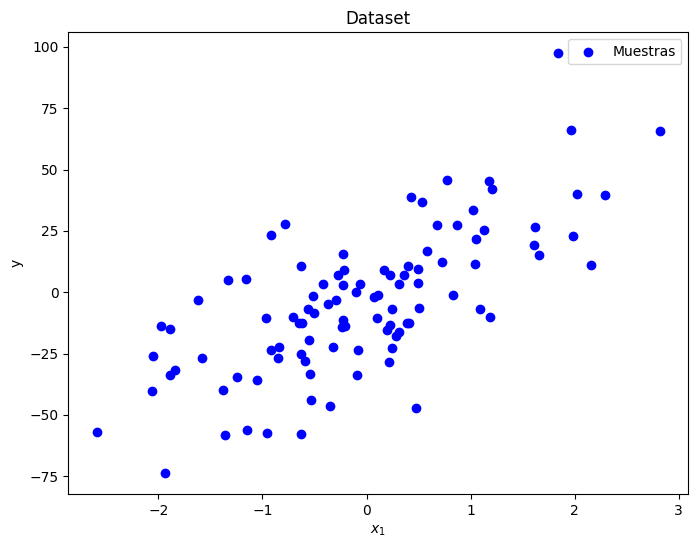

In [2]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 1, noise = 20.0, random_state = 25)
X = X.flatten()

# Visualizamos

plt.figure(figsize = (8,6))

plt.scatter(X, y, color = 'blue', label = 'Muestras')

plt.xlabel('$x_1$')
plt.ylabel('y')
plt.title('Dataset')

plt.legend()
plt.show()

# **Minimos Cuadrados**

El método de **Minimos Cuadrados** en **regresión lineal** se obtiene como el **estimador de maxima verosimilitud** (MLE) cuando se asume que las observaciones $y_i$ son independientes y provienen de una **distribución normal** con media $w^T x$ y varianza constante $\sigma^2$

$$p(y \mid w, \theta)$$
$$p(y \mid w, X, \sigma^2) = \mathcal{N}(y \mid Xw, \sigma^2 I_n)$$
$$p(y \mid w, X, \sigma^2) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(y_i - w^T x_i)^2}{2\sigma^2}}$$

**Verosimilitud**

$$p(y \mid w, X, \sigma^2) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(y_i - w^T x_i)^2}{2\sigma^2}}$$

**Log Verosimilitud**  

$$LL(y \mid w, X, \sigma^2) = \log \left(\prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(y_i - w^T x_i)^2}{2\sigma^2}}\right)$$
$$LL(y \mid w, X, \sigma^2)  = \sum_{i=1}^n \log \left(\frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(y_i - w^T x_i)^2}{2\sigma^2}}\right)$$

$$LL(y \mid w, X, \sigma^2)   = - \frac{n}{2} \log \left(2\pi\sigma^2\right) - \frac{1}{2 \sigma^2} \cdot (y - Xw)^T (y - Xw)$$

**Negative Log Verosimilitud** 

$$NLL(y \mid w, X, \sigma^2)   = \frac{n}{2} \log \left(2\pi\sigma^2\right) + \frac{1}{2 \sigma^2} \cdot (y - Xw)^T (y - Xw)$$

**Nota:** Usamos el **Negative Log Verosimilitud** ya que convertimos un problema de maximizacion en minimizacion lo cual es mas estable computacionalmente

In [3]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 1, noise = 20.0, random_state = 25)
X = X.flatten()

# Definimos la Verosimilitud (Evitamos Overflow)

def likelihood(X, y, weights, sigma2, bias, norm = True): 

    n = len(y) 

    log_likehood = np.zeros_like(weights, dtype = float)

    for idx, weight in enumerate(weights): 

        residuals = y - (X * weight + bias)

        log_likehood[idx] = - ((n / 2) * np.log(2 * np.pi * sigma2)) - ((1 / (2 * sigma2)) * np.sum(residuals**2))

    if norm:
        log_likehood = np.exp(log_likehood - np.max(log_likehood)) / np.sum(np.exp(log_likehood - np.max(log_likehood)))

    return log_likehood 


# Visualizamos 

w_vals = np.linspace(-10, 30, 1000)

def viz(sigma2 = 1, bias = 0, w = 0):

    log_likehood = likelihood(X, y, w_vals, sigma2, bias) 
    
    fig, axes = plt.subplots(1, 2, figsize = (24,6))

    y_pred = w * X + bias

    axes[0].scatter(X, y, label = "Muestras", color = "black")
    axes[0].plot(X, y_pred, color = "blue", label = rf"$y = {w:0.2f}x + {bias}$" if np.sign(bias) == 1 else rf"$y = {w:0.2f}x {bias}$")
    
    for xi, yi, ypi in zip(X, y, y_pred):
        axes[0].plot([xi, xi], [yi, ypi], color = "red", linestyle = "--", alpha = 0.7)
    
    axes[0].set_title(f"Regresion Lineal")
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("y")
    axes[0].legend()

    axes[1].plot(w_vals, log_likehood, label = "Likelihood", color = "green")
    axes[1].axvline(x = w, color = "blue", linestyle = "--", label = rf"$w_1$ = {w}")
    axes[1].set_title("MLE")
    axes[1].set_xlabel(r"$w_1$")
    axes[1].set_ylabel("PDF")
    axes[1].legend()

    plt.tight_layout()
    return plt.show()

interact(viz, sigma2 = FloatText(value = 1, description = 'sigma2'), w = FloatText(value = 0, description = 'w'), bias = FloatText(value = 0, description = 'bias'))
plt.show()

interactive(children=(FloatText(value=1.0, description='sigma2'), FloatText(value=0.0, description='bias'), Fl…

### **Solucion Analitica** 

**Derivamos Pracialmente Respecto a los Parametros** 

* Parametro: $w$ 

$$\frac{\partial NLL(y \mid w, X, \sigma^2) }{\partial w} = \frac{1}{2 \sigma^2} \cdot (y - Xw)^T (y - Xw)$$
$$\frac{\partial NLL(y \mid w, X, \sigma^2) }{\partial w} =  \frac{1}{2 \sigma^2} \left[y^Ty - y^TXw - w^TX^Ty + w^TX^TXw\right]$$
$$\frac{\partial NLL(y \mid w, X, \sigma^2) }{\partial w} =  \frac{1}{2 \sigma^2} \left[y^Ty - 2 y^TXw + w^TX^TXw\right]$$
$$\frac{\partial NLL(y \mid w, X, \sigma^2) }{\partial w} =  \frac{1}{2 \sigma^2} \left[- 2 y^TXdw + dw^TX^TXw + w^TX^TXdw\right]$$
$$\frac{\partial NLL(y \mid w, X, \sigma^2) }{\partial w} =  \frac{1}{2 \sigma^2} \left[- 2 y^TXdw + 2 w^TX^TXdw\right]$$
$$\frac{\partial NLL(y \mid w, X, \sigma^2) }{\partial w} =  \frac{1}{\sigma^2} \left[w^TX^TXdw - y^TXdw \right]$$

$$\nabla_w^T = \frac{1}{\sigma^2} \left[w^TX^TX - y^TX\right]$$
$$\nabla_w = \frac{1}{\sigma^2} \left[X^TXw - X^Ty\right]$$

**Máxima Verosimilitud** 

* Parametro: $w$ 

$$\hat{w}_{MAP} = \text{argmin}_{w} NLL(y \mid w, X, \sigma^2) \rightarrow \frac{\partial NLL(y \mid w, X, \sigma^2)}{\partial w} = 0$$

$$0 = \frac{1}{\sigma^2} \left[X^TXw - X^Ty\right]$$
$$0 = X^TXw - X^Ty$$
$$w = \left(X^TX\right)^{-1} X^Ty$$

**Nota:** $X^TX$  es la **matriz de Gram**, la misma es invertible si el conjunto de vectores columnas de $X$ son **linealmente independientes**, esto sucede normalmente cuando $N > D$

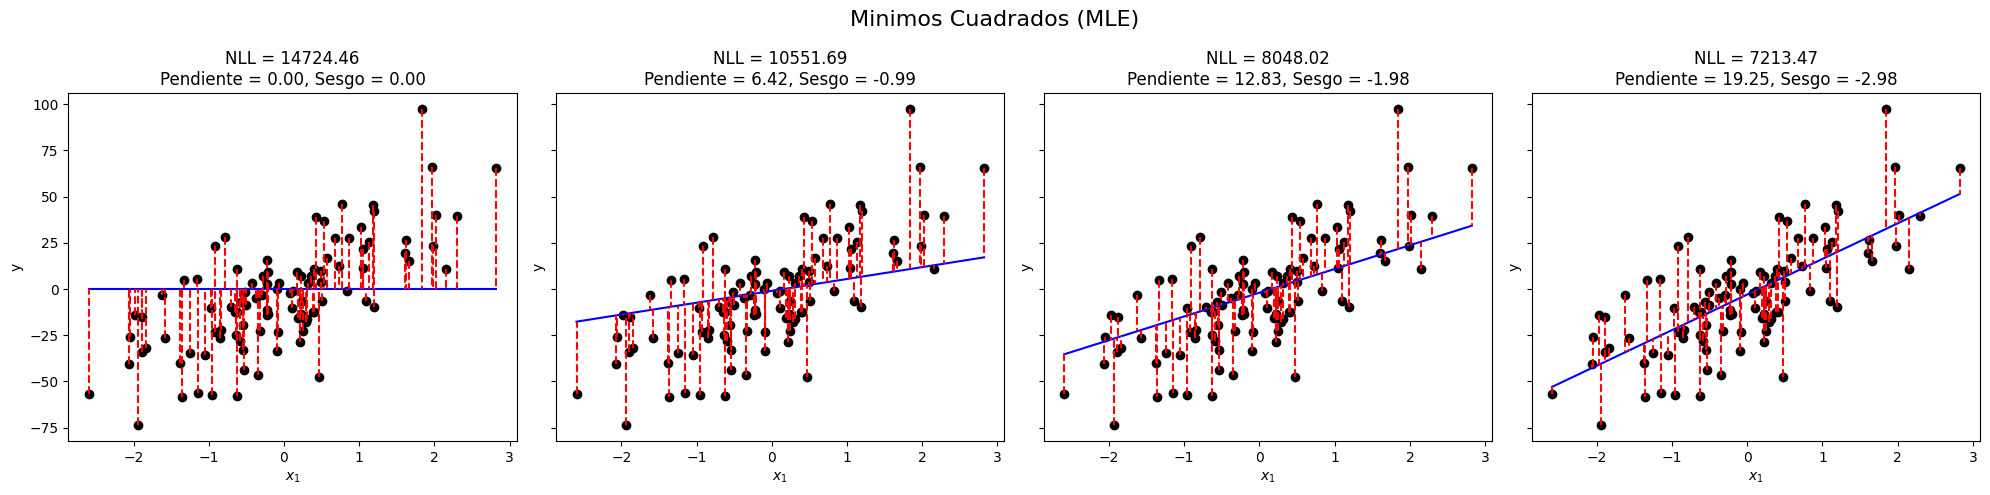

In [4]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 1, noise = 20.0, random_state = 25)
X = X.flatten()

# Definimos la Funcion de Negative Log-Likehood

def NLL(X, w, sigma2 = 1): 

    n = X.shape[0]    

    resid = y - X @ w

    nll_likelihood = (n / 2) * np.log(2 * np.pi * sigma2) + (resid @ resid) / (2 * sigma2) 

    return nll_likelihood   

# Obtenemos el parametro de Maxima Verosimilitud 

sigma2 = 3

X_with_bias = np.vstack([np.ones_like(X), X]).T

w_opt = np.linalg.inv(X_with_bias.T @ X_with_bias) @ X_with_bias.T @ y

m_opt = w_opt[1]
b_opt = w_opt[0]

# Definimos unos Pasos Intermedios a los optimos

n_steps = 4 
w_init = np.array([0, 0]) 

w_list = [w_init + (w_opt - w_init) * i / (n_steps-1) for i in range(n_steps)]

# Visualizamos 

fig, axes = plt.subplots(1, n_steps, figsize = (20,5), sharey = True)

for ax, weights in zip(axes, w_list):

    nll = NLL(X_with_bias, weights, sigma2)    

    x_line = np.linspace(X.min(), X.max(), 100)
    y_line = weights[1]*x_line + weights[0]

    ax.scatter(X, y, color = 'black', label = 'Muestras')
    ax.plot(x_line, y_line, color = 'blue', label = 'Recta')

    for xi, yi in zip(X, y):
        y_pred = weights[1] * xi + weights[0]
        ax.plot([xi, xi], [yi, y_pred], color = 'red', linestyle = '--')    
    
    ax.set_title(f'NLL = {nll :.2f}\nPendiente = {weights[1] :.2f}, Sesgo = {weights[0] :.2f}')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel('y')

plt.suptitle('Minimos Cuadrados (MLE)', fontsize = 16)
plt.tight_layout()
plt.show()

### **Solucion Convexa** 

Podemos calcular el parametro de **maxima verosimilitud** $w$, como un problema de **optimizacion convexa** utilizando la funcion de **Negative Log-Verosimilitud**:

$$NLL(y \mid w, X, \sigma^2) = \frac{n}{2} \log 2\pi\sigma^2 + \frac{1}{2 \sigma^2} \cdot (y - Xw)^T (y - Xw)$$

Nos quedamos con los terminos que dependen de $w$

$$\text{Loss} = \frac{1}{2 \sigma^2} \cdot (y - Xw)^T (y - Xw)$$
$$\text{Loss} = (y - Xw)^T (y - Xw)$$

Podemos resolverlo como un **problema convexo** sin restricciones 

$$\begin{align*}
\text{minimizar}_w \quad & ||y - Xw||_2^2
\end{align*}$$

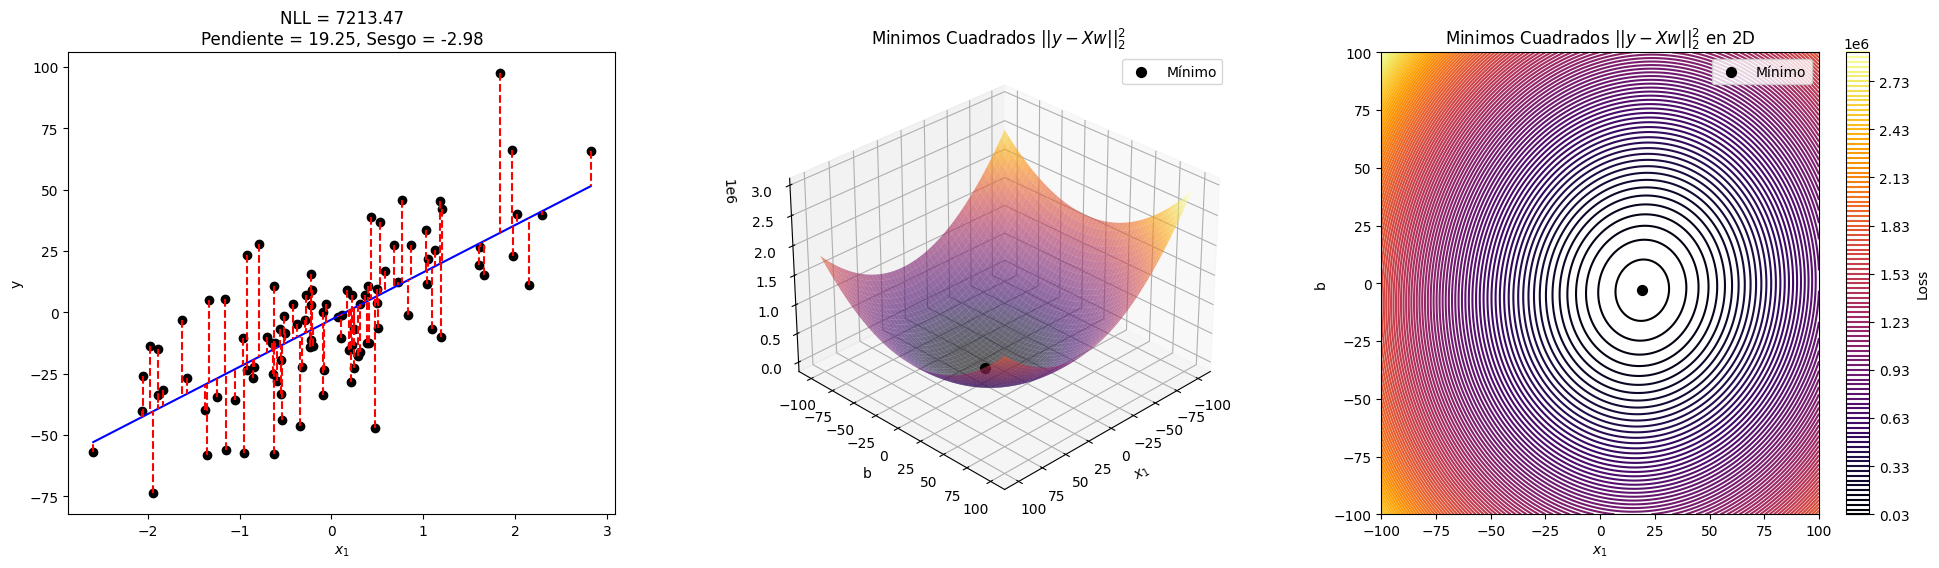

In [5]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 1, noise = 20.0, random_state = 25)
X = X.flatten()

# Definimos la Funcion de Negative Log-Likehood

def NLL(X, w, sigma2 = 1): 

    n = X.shape[0]    

    resid = y - X @ w

    nll_likelihood = (n / 2) * np.log(2 * np.pi * sigma2) + (resid @ resid) / (2 * sigma2) 

    return nll_likelihood  

# Obtenemos el parametro de Maxima Verosimilitud

sigma2 = 3

X_with_bias = np.vstack([np.ones_like(X), X]).T

weights = cp.Variable(2)
objective = cp.Minimize(cp.sum_squares(y - X_with_bias @ weights))

problem = cp.Problem(objective)
problem.solve()

w_opt = weights.value

m_opt = w_opt[1]
b_opt = w_opt[0]

# Calculamos Negative Log-Likehood 

y_pred = X_with_bias @ w_opt

nll = NLL(X_with_bias, w_opt, sigma2)  

# Visualizamos 

fig = plt.figure(figsize = (24,6))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, projection = '3d')
ax3 = fig.add_subplot(1, 3, 3)

x_line = np.linspace(X.min(), X.max(), 100)
y_line = w_opt[1]*x_line + w_opt[0]

ax1.scatter(X, y, color = 'black', label = 'Muestras')
ax1.plot(x_line, y_line, color = 'blue', label = 'Recta')

for xi, yi in zip(X, y):
    y_pred = w_opt[1] * xi + w_opt[0]
    ax1.plot([xi, xi], [yi, y_pred], color = 'red', linestyle = '--')    
    
ax1.set_title(f'NLL = {nll :.2f}\nPendiente = {w_opt[1] :.2f}, Sesgo = {w_opt[0] :.2f}')
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel('y')

m_vals = np.linspace(-100, 100, 500)
b_vals = np.linspace(-100, 100, 500)
M, B = np.meshgrid(m_vals, b_vals)

loss = np.zeros_like(M)

for i in range(M.shape[0]):
    for j in range(M.shape[1]):

        y_pred_tmp = M[i, j] * X + B[i, j]
        loss[i, j] = np.sum((y - y_pred_tmp)**2)

ax2.plot_surface(M, B, loss, cmap = 'inferno', alpha = 0.6)
ax2.scatter(m_opt, b_opt, np.sum((y - (m_opt * X + b_opt))**2), color = 'black', s = 50, label = 'Mínimo')

ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'b')
ax2.set_title(r'Minimos Cuadrados $||y - Xw||_2^2$')
ax2.view_init(elev = 30, azim = 45)
ax2.legend()

contours = ax3.contour(M, B, loss, levels = 100, cmap = 'inferno')

cbar = fig.colorbar(contours, ax = ax3)
cbar.set_label('Loss')

ax3.scatter(m_opt, b_opt, color = 'black', s = 50, label = 'Mínimo')
ax3.set_xlabel(r'$x_1$')
ax3.set_ylabel(r'b')
ax3.set_title(r'Minimos Cuadrados $||y - Xw||_2^2$ en 2D')
ax3.legend()

plt.show()

# **3D**

### **Dataset**

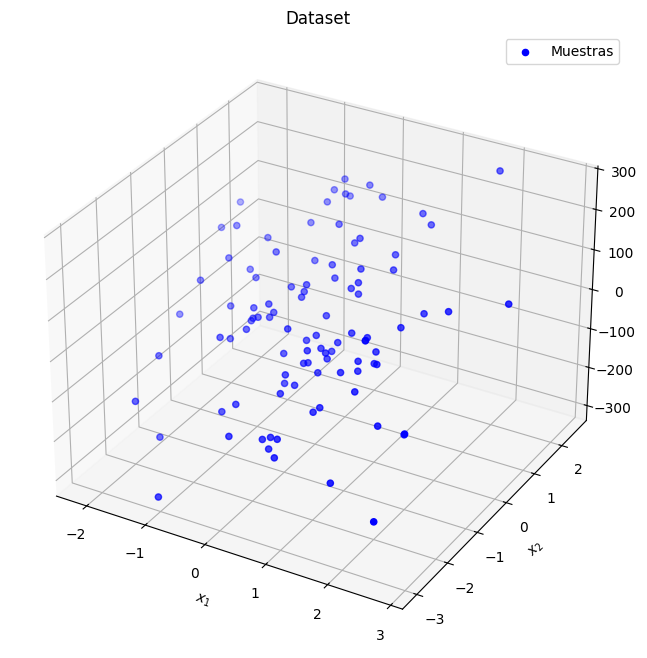

In [6]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 2, noise = 20.0, random_state = 25)

# Visualizamos

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(X[:, 0], X[:, 1], y, c = 'blue', marker = 'o', label = 'Muestras')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Dataset')

plt.legend()
plt.show()

In [7]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples=100, n_features=2, noise=20.0, random_state=25)

# Definimos la Verosimilitud (Evitamos Overflow)

def likelihood(X, y, W1, W2, sigma2, bias, norm = True):

    n = len(y)

    log_likehood = np.zeros_like(W1, dtype = float)

    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):

            weight = np.array([W1[i,j], W2[i,j]]).reshape(-1)

            residuals = y - (X @ weight + bias)

            log_likehood[i, j] = - ((n / 2) * np.log(2 * np.pi * sigma2)) - ((1 / (2 * sigma2)) * np.sum(residuals**2))

    if norm:
        log_likehood = np.exp(log_likehood - np.max(log_likehood)) / np.sum(np.exp(log_likehood - np.max(log_likehood)))

    return log_likehood

# Visualizamos 

w1_vals = np.linspace(-20, 200, 200)
w2_vals = np.linspace(-20, 125, 500)

W1, W2 = np.meshgrid(w1_vals, w2_vals)

def viz(w1 = 0, w2 = 0, sigma2 = 1, bias = 0):

    log_likehood = likelihood(X, y, W1, W2, sigma2, bias, norm = True)
   
    fig = plt.figure(figsize = (18,6))
    
    ax0 = fig.add_subplot(1, 2, 1)
    cs0 = ax0.contourf(W1, W2, log_likehood, levels = 100, cmap = 'viridis')
    ax0.set_title("Likelihood")
    ax0.set_xlabel(r"$w_1$")
    ax0.set_ylabel(r"$w_2$")
    ax0.set_xlim(0, 10)
    ax0.set_ylim(95, 100)
    fig.colorbar(cs0, ax = ax0)

    ax3 = fig.add_subplot(1, 2, 2, projection='3d')
    x1_line = np.linspace(X[:,0].min(), X[:,0].max(), 20)
    x2_line = np.linspace(X[:,1].min(), X[:,1].max(), 20)

    X1, X2 = np.meshgrid(x1_line, x2_line)

    Y_plane = bias + w1*X1 + w2*X2

    ax3.scatter(X[:,0], X[:,1], y, color = 'black', s = 20, label = "Muestras")
    ax3.plot_surface(X1, X2, Y_plane, alpha = 0.5, color = 'red')
    ax3.set_xlabel(r'$x_1$')
    ax3.set_ylabel(r'$x_2$')
    
    plt.tight_layout()
    plt.show()

interact(viz, w1 = FloatText(value = 0, description = r'w1'), w2 = FloatText(value = 0, description = r'w2'), sigma2 = FloatText(value = 1, description = r'sigma2'), 
        bias = FloatText(value = 0, description = r'bias'))
plt.show()

interactive(children=(FloatText(value=0.0, description='w1'), FloatText(value=0.0, description='w2'), FloatTex…

### **Solucion Analitica**

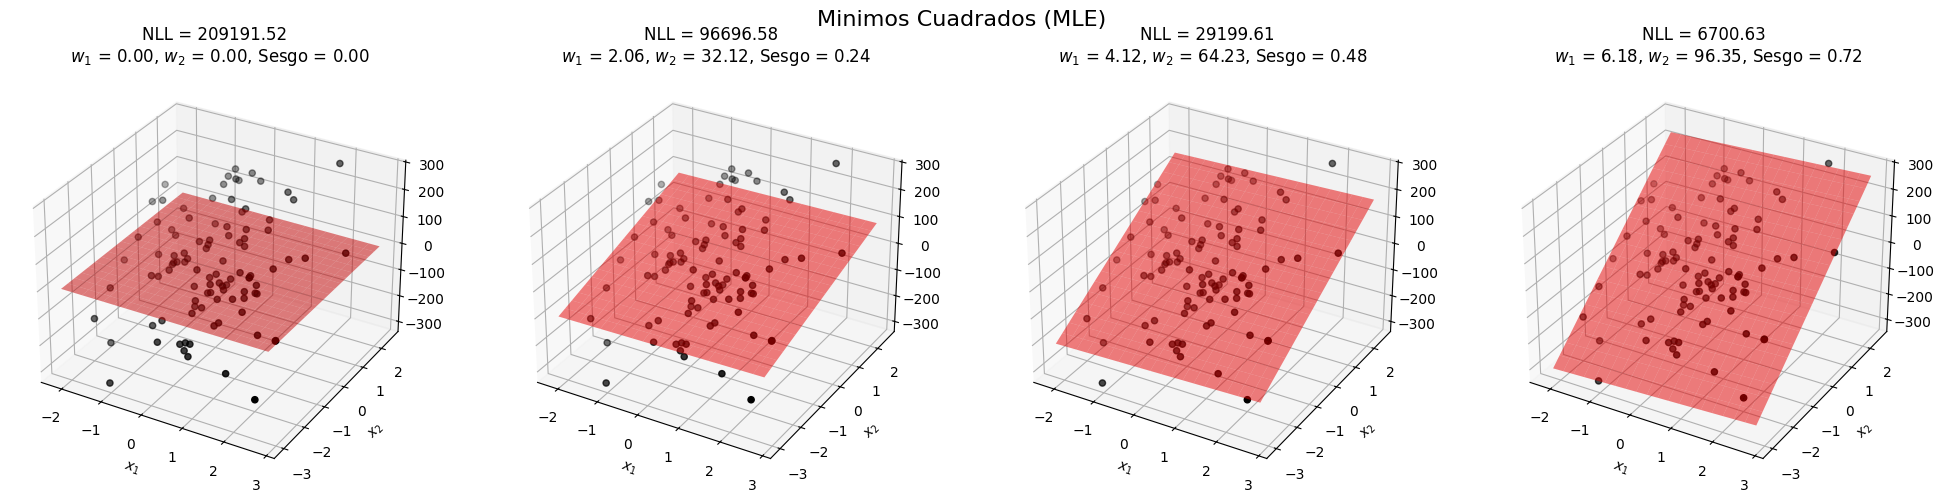

In [8]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 2, noise = 20.0, random_state = 25)

# Definimos la Funcion de Negative Log-Likehood

def NLL(X, w, sigma2 = 1): 

    n = X.shape[0]    

    resid = y - X @ w

    nll_likelihood = (n / 2) * np.log(2 * np.pi * sigma2) + (resid @ resid) / (2 * sigma2) 

    return nll_likelihood   

# Obtenemos el parametro de Maxima Verosimilitud

sigma2 = 3

X_with_bias = np.hstack([np.ones((X.shape[0], 1)), X])

w_opt = np.linalg.inv(X_with_bias.T @ X_with_bias) @ X_with_bias.T @ y

# Definimos unos Pasos Intermedios a los optimos

n_steps = 4 
w_init = np.array([0, 0, 0]) 

w_list = [w_init + (w_opt - w_init) * i / (n_steps-1) for i in range(n_steps)]

# Visualizamos 

x1_line = np.linspace(X[:,0].min(), X[:,0].max(), 20)
x2_line = np.linspace(X[:,1].min(), X[:,1].max(), 20)

X1, X2 = np.meshgrid(x1_line, x2_line)

fig = plt.figure(figsize = (20,5))

for idx, weights in enumerate(w_list, 1):

    ax = fig.add_subplot(1, n_steps, idx, projection = "3d")

    nll = NLL(X_with_bias, weights, sigma2)    

    Y_plane = weights[0] + weights[1]*X1 + weights[2]*X2

    ax.scatter(X[:,0], X[:,1], y, color = "black", s = 20, label = "Muestras")
    ax.plot_surface(X1, X2, Y_plane, alpha = 0.5, color = "red", label = 'Plano') 
    
    ax.set_title(f'NLL = {nll:.2f} \n $w_1$ = {weights[1]:.2f}, $w_2$ = {weights[2]:.2f}, Sesgo = {weights[0]:.2f}')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')

plt.suptitle('Minimos Cuadrados (MLE)', fontsize = 16)
plt.tight_layout()
plt.show()

### **Solucion Convexa**

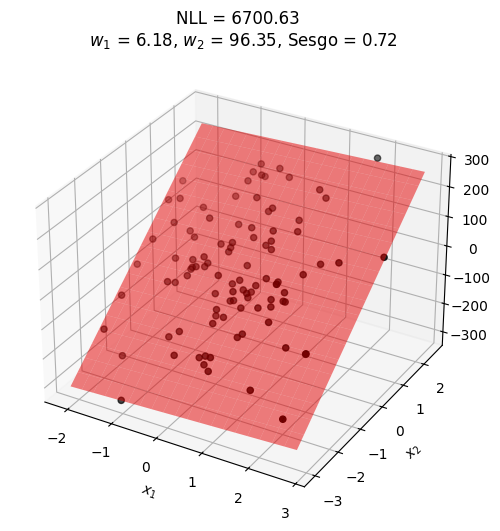

In [9]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 2, noise = 20.0, random_state = 25)

# Definimos la Funcion de Negative Log-Likehood

def NLL(X, w, sigma2 = 1): 

    n = X.shape[0]    

    resid = y - X @ w

    nll_likelihood = (n / 2) * np.log(2 * np.pi * sigma2) + (resid @ resid) / (2 * sigma2) 

    return nll_likelihood  

# Obtenemos el parametro de Maxima Verosimilitud

sigma2 = 3

X_with_bias = np.hstack([np.ones((X.shape[0], 1)), X])

weights = cp.Variable(3)
objective = cp.Minimize(cp.sum_squares(y - X_with_bias @ weights))

problem = cp.Problem(objective)
problem.solve()

w_opt = weights.value

m_opt = w_opt[1]
b_opt = w_opt[0]

# Calculamos Negative Log-Likehood 

y_pred = X_with_bias @ w_opt

nll = NLL(X_with_bias, w_opt, sigma2)  

# Visualizamos 

x1_line = np.linspace(X[:,0].min(), X[:,0].max(), 20)
x2_line = np.linspace(X[:,1].min(), X[:,1].max(), 20)

X1, X2 = np.meshgrid(x1_line, x2_line)

fig = plt.figure(figsize = (24,6))

ax1 = fig.add_subplot(1, 1, 1, projection = '3d')

Y_plane = b_opt + w_opt[1]*X1 + w_opt[2]*X2

ax1.scatter(X[:,0], X[:,1], y, color = "black", s = 20, label = "Muestras")
ax1.plot_surface(X1, X2, Y_plane, alpha = 0.5, color = "red") 
    
ax1.set_title(f'NLL = {nll:.2f} \n $w_1$ = {w_opt[1]:.2f}, $w_2$ = {w_opt[2]:.2f}, Sesgo = {b_opt:.2f}')
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')

plt.show()